In [6]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import csv
import random
import pandas as pd
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()  # For easy reset of notebook state.

### Class for Linear Layer in a neural network

In [8]:
class Linear(layers.Layer):
    '''
    Class for initializing a Layer in Neural Network
    '''
    def __init__(self, units=32):
        '''
        constructor
        :param units:  number of nodes in the layer
        '''
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        '''
        Initializes the weight and bias values of the layer
        :param w:  weights
        :param b:  bias
        '''
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        '''
        layer output
        '''
        return tf.matmul(inputs, self.w) + self.b

### Create the Multi-layer Perceptron block

In [9]:
class MLPBlock(layers.Layer):
    '''
    Neural Network Block
    '''
    def __init__(self):
        '''
        Architecture of the neural network i.e.
        number of layers and nodes in each layer
        '''
        super(MLPBlock, self).__init__()
        self.layers = []     
        self.layers.append(Linear(312))
        self.layers.append(Linear(128))
        self.layers.append(Linear(1))

    def call(self, inputs):
        '''
        Forward pass of the neural network
        '''
        inputs = tf.reshape(inputs, (inputs.shape[0], -1))
        x = self.layers[0](inputs)
        x = tf.nn.relu(x)
        x = self.layers[1](x)
        x = tf.nn.relu(x)
        x = self.layers[2](x)
        return tf.math.sigmoid(x)

### Create batches out of give list

In [1]:
# a = np.arange(20).reshape((10,2))
def divide_chunks(l, n): 
    '''
    Divides a list into batches of given size
    '''
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

### Create train and validation batches

In [47]:
def create_batches():
    train_batches = []
    valid_batches = []
    for t in range(10):
        train_indices = [(index,1) if np.argmax(y)==t else (index,0) for index,y in enumerate(trainY)]
        valid_indices = [(index,1) if np.argmax(y)==t else (index,0) for index,y in enumerate(validY)]

        train_indices = np.array(sorted(train_indices, key=lambda tup:-tup[1]))
        train_indices = train_indices[: 2*len(np.where(train_indices[:,1]==1)[0])]
        random.shuffle(train_indices)

        valid_indices = np.array(sorted(valid_indices, key=lambda tup:-tup[1]))
        valid_indices = valid_indices[: 2*len(np.where(train_indices[:,1]==1)[0])]
        random.shuffle(valid_indices)

        train_batches.append(np.asarray(list(divide_chunks(train_indices, 20))))
        valid_batches.append(np.asarray(list(divide_chunks(valid_indices, 20))))
    return train_batches, valid_batches

## Code with custom Data Loader

In [67]:
'''
Code with custom data loader
'''
def main():
    # load data
    trainX = pd.read_csv('datasets/mnist/trainX.tsv', sep="\t", header=None, index_col=False).to_numpy()
    trainY = pd.read_csv('datasets/mnist/trainY.tsv', sep="\t", header=None, index_col=False).to_numpy()
    testX = pd.read_csv('datasets/mnist/testX.tsv', sep="\t", header=None, index_col=False).to_numpy()
    testY = pd.read_csv('datasets/mnist/testY.tsv', sep="\t", header=None, index_col=False).to_numpy()
    validX = pd.read_csv('datasets/mnist/validX.tsv', sep="\t", header=None, index_col=False).to_numpy()
    validY = pd.read_csv('datasets/mnist/validY.tsv', sep="\t", header=None, index_col=False).to_numpy()
    n_epochs = 100
    train_losses = []
    valid_losses = []
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    mse_loss_fn = tf.keras.losses.MeanSquaredError()
    bce = tf.keras.losses.BinaryCrossentropy()
    train_batches, valid_batches = create_batches()
    net = MLPBlock()

    for epoch in range(n_epochs):
        print('Epoch:', epoch)
        epoch_train_loss = 0
        epoch_valid_loss = 0
        
        for task in range(10):
            task_loss = 0
            size = 0
            for batch in train_batches[t]:
                '''
                batchX = trainX[batch[:,0]]
                batchY = trainY[batch[:,1]]
                '''
                with tf.GradientTape() as tape:
                    output = net(trainX[batch[:,0]])
                    size += len(trainX[batch[:,0]])
                    batch_loss = mse_loss_fn(np.argmax(trainY[batch[:,1]], axis=0), output)
                    task_loss += batch_loss
                grads = tape.gradient(batch_loss, net.trainable_weights)
                optimizer.apply_gradients(zip(grads, net.trainable_weights))
            task_loss /= size
#             train_losses.append(task_loss)
            epoch_train_loss += task_loss
            print('mean train loss for task %s: %s' % (task, task_loss))

            valid_loss = 0
            size = 0
            for batch in valid_batches[t]:
                output = net(validX[batch[:,0]])
                size += len(validX[batch[:,0]])
                batch_loss = mse_loss_fn(np.argmax(validY[batch[:,1]], axis=0), output)
                valid_loss += batch_loss
            valid_loss /= size
#             valid_losses.append(valid_loss)
            epoch_valid_loss += valid_loss
            print('mean valid loss for task %s: %s' % (task, valid_loss))
            print('----------------------------------------------')
        
        train_losses.append(epoch_train_loss/10)
        valid_losses.append(epoch_valid_loss/10)
        print('xxxxxxxxxxxxxxxx end of Epoch xxxxxxxxxxxxxxxx\n\n')
    
    
    plot_losses(train_losses, valid_losses)
    accuracy(testX, testY, net, mse_loss_fn)

### Plot graphs for losses

train_losses:


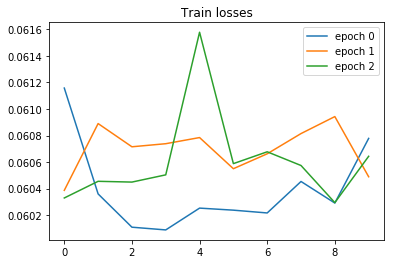

In [70]:
def plot_losses(train_losses, valid_losses):
    # train_losses = np.asarray(train_losses).reshape((3,10))
    # valid_losses = np.asarray(valid_losses).reshape((3,10))
#     for c,row in enumerate(train_losses):
#         plt.plot(row, label=('epoch '+str(c)))
    plt.plot(train_losses, label='Train loss per epoch')
    plt.plot(valid_losses, label='Validation loss per epoch')
    plt.title('Loss plot')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.legend(loc='upper right')
#     plt.show()
    plt.savefig('Loss_plot.png')

test_losses:


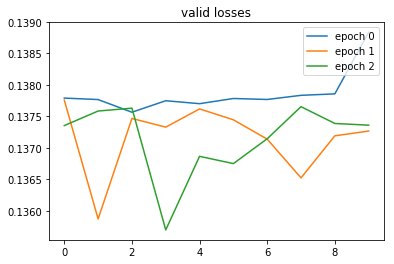

In [71]:
# print('test_losses:')
# for c,row in enumerate(valid_losses):
#     plt.plot(row, label=('epoch '+str(c)))
# plt.title('valid losses')
# plt.legend(loc='upper right')
# plt.show()

### Calculate test loss and accuracy

In [3]:
def accuracy(testX, testY, net, mse_loss_fn):
    acc = 0
    total = 0
    test_dataset = tf.data.Dataset.from_tensor_slices((testX, len(testY)*[1]))
    test_dataset = test_dataset.shuffle(buffer_size=1024).batch(64)
    test_loss = 0
    for x_batch_test, y_batch_test in test_dataset:
        test_output = net(x_batch_test)
        test_loss += mse_loss_fn(y_batch_test, test_output)
        for (output,target) in zip(test_output, y_batch_test):
    #         if tf.math.argmax(output) == tf.math.argmax(y_batch_test[index]):
            if output >= 0.5:
                temp = 1
            else:
                temp = 0
            if temp == 1:
                acc += 1
            total += 1
    print('\n\n\n################### Test Results ###################')
    print('average accuracy:', acc/total)
    print('Test Loss: ', test_loss/len(list(test_dataset)))
    with open('test results.txt', 'w+') as file:
        file.write('\n\n\n################### Test Results ###################')
        file.write('average accuracy:', acc/total)
        file.write('Test Loss: ', test_loss/len(list(test_dataset)))

SyntaxError: unexpected EOF while parsing (<ipython-input-3-0484ebc4073e>, line 22)

In [ ]:
if __name__ == '__main__':
    main()